## Prepearing data

In [1]:
import xgboost
import numpy as np
import pandas as pd
import shap

# load JS visualization code to notebook
shap.initjs() 

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data_features = pd.read_hdf('/home/olgako/data/data_features_JetHT.hdf5', "data")
labels = 1-pd.read_hdf('/home/olgako/data/labels_JetHT.hdf5', 'labels')
sublabels = pd.read_hdf('//data/cms2010/data_not_f_JetHT.hdf5', "data")

In [3]:
data_features.shape, sublabels.shape

((162990, 2470), (162990, 20))

In [4]:
np.where(sublabels['new_json'] != labels)

(array([], dtype=int64),)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import time

In [6]:
indx_train = np.arange(data_features.shape[0]-int(data_features.shape[0]/5), dtype='int32')
indx_test = np.arange(data_features.shape[0]-int(data_features.shape[0]/5),data_features.shape[0], dtype='int32')

#indx_train, indx_test = train_test_split(np.arange(data.shape[0], dtype='int32'), stratify=labels, test_size=0.1, random_state = 1)

In [7]:
num_good = np.sum(labels)
num_bad = len(labels)-np.sum(labels)

weights = 0.5 / np.where(labels == 0.0, num_good, num_bad)
weights *= len(labels)

In [8]:
y_train = np.array(labels.iloc[indx_train], 'float32')
#y_val = np.array(labels.iloc[indx_val], 'float32')
y_test = np.array(labels.iloc[indx_test], 'float32')

X_train = np.array(data_features.iloc[indx_train], 'float32')
#X_val = np.array(data_features.iloc[indx_val], 'float32')
X_test = np.array(data_features.iloc[indx_test], 'float32')

weights_train = weights[indx_train]
#weights_val = weights[indx_val]
weights_test = weights[indx_test]

ids_train = sublabels[['runId', 'lumiId']].iloc[indx_train]
ids_test = sublabels[['runId', 'lumiId']].iloc[indx_test]

In [9]:
feature_names = data_features.columns

In [10]:
Muon_features = [s for s in feature_names if (s[:3] == 'qMu')]# and (s[3:7] != 'Cosm')]
Pho_features = [s for s in feature_names if s[:4] == 'qPho']
Cal_features = [s for s in feature_names if s[:4] == 'qCal']
PF_features = [s for s in feature_names if s[:3] == 'qPF']

channels_features = dict()

channels_features['muons'] = Muon_features
channels_features['photons'] = Pho_features
channels_features['PF'] = PF_features
channels_features['calo'] = Cal_features

[ (g, len(fs)) for g, fs in channels_features.items() ]

[('muons', 439), ('photons', 224), ('PF', 878), ('calo', 280)]

## train any classifier

In [11]:
import xgboost as xgb
xgb_clf  = xgb.XGBClassifier(n_estimators=80, max_depth=10, eta=0.1, n_jobs=-1, random_state=111, silent=False)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=80, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=111, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

In [12]:
model = xgb_clf

## some runs with given cause of anomaly

In [14]:
dict_causes = {
 273150:" [[61, 64], [66, 75]],     	Ecal excluded",
 273296:" [[1, 94]],			Pixe excluded",
 273426:" [[1, 59], [64, 64], [66, 69]],inefficeincy in EE",
 273445:" [[5, 6]],			tracker off  seen by many systems",
 274142:" [[99, 100]],			pixel and tracker off",
 274157:" [[103, 534]],		EB minus has region with low efficiency",
 274282:" [[86, 88]],			tracker is off --> particle flow object are affected",
 275326:" [[1, 169]],			sistrip excl",
 275757:" [[104, 122]],		low DCS: HBHE. nothing on PF plot",
 275758:" [[1, 4]],			part of hcal not available --> JetMET reconstruction suffers",
 275764:" [[1, 31]],			pixel off",
 275766:" [[1, 23], [25, 60]],		lower tracker efficiency",
 275768:" [[1, 79]],			lower tracker efficiency",
 275769:" [[1, 22]],			pixel not in Data Acquisition",
 275781:" [[1, 29]],			EB+16, +17, +18 are excluded due to a problem with VME crateS206h",
 275783:" [[1, 1634]],			strip EXCL",
 275838:" [[1, 51]],			strip EXCL",
 275922:" [[4, 6]],			low stat",
 276064:" [[1, 22]],			hot trigger tower seen in EE-07 (high occupancy and Et TP) which cause  ~100% deadtime",
 276071:" [[1, 22]],			strip EXCL",
 276095:" [[1, 5]],			low stat",
 276237:" [[1, 5]],			ECAL, HCAL, PIXEL excluded",
 276453:" [[1, 8], [10, 125]],		EB-17 (FED 626): was excluded (because of cooling failure)",
 276455:" [[1, 401]],			strip EXCL",
 276456:" [[1, 182]],			strip EXCL",
 276457:" [[1, 19]],			sistrip not in DAQ",
 277217:" [[12, 14]],			Short collision run with strip in error in DCS and pixel in error in DAQ. For physically meaningful lumisections 33-47, the total rate is zero. L1T flags marked as bad due to this",
 277933:" [[1, 42]],			ECAL EE+09 FED 648 removed from all LS in the run because it was causing 100% dead time. EE+09 was not masked, so all LS in this run are bad",
 278309:" [[1, 10]],			EE-04 FED 607 TT disabled in LS [1-10] according to express dataset (LS# 10)",
 278821:" [[1, 33], [36, 37]],		FED652 in error, EE+04 is off",
 279028:" [[1, 17]],			strip EXCL",
 279995:" [[1, 8]],			hcal water colling issues",
 280002:" [[1, 111]],			ecal excluded",
 280006:" [[1, 68]],			EB-11 token ring missing",
 280007:" [[1, 36]],			Low voltage channel broken in EB",
 280239:" [[1, 9]],			strip EXCL",
 280241:" [[1, 11]],			strip EXCL",
 281663:" [[61, 172]],			Timing shifted by 5ns due to TCDS* problem ",
 281674:" [[1, 45]],			Timing shifted by 5ns due to TCDS* problem",
 281680:" [[1, 31]],			Timing shifted by 5ns due to TCDS* problem",
 281974:" [[79, 85]],			pixel High voltage OFF",
 282408:" [[80, 191]],			strip EXCL",
 282707:" [[79, 81]],			pixel High voltage OFF",
 282796:" [[80, 82]],			pixel High Voltage off",
 282921:" [[1, 152]]		        strip EXCL"

    
}

## SHAP to explain predictions

In [16]:
shap_values_test = shap.TreeExplainer(model).shap_values(X_test)
shap_values_train = shap.TreeExplainer(model).shap_values(X_train)

In [17]:
min_num_neg = 2000
for i in range(shap_values_train.shape[0]):
    cur = len(shap_values_train[i,:-1][shap_values_train[i,:-1]<0])
    if cur < min_num_neg:
        min_num_neg = cur
for i in range(shap_values_test.shape[0]):
    cur = len(shap_values_train[i,:-1][shap_values_test[i,:-1]<0])
    if cur < min_num_neg:
        min_num_neg = cur
        
print(min_num_neg)

479


273150 is not found
273296 is not found
273426 is not found
273445 is not found
274142 is not found
274157 is not found
274282 is not found
275326 is not found

275757  [[104, 122]],		low DCS: HBHE. nothing on PF plot

this run from TRAIN set
sum of features' influences from all lumis, 20 the most important

Index(['qPFJet4CHSEta_3', 'qEEchi2_3', 'qEEchi2_1', 'qPFJetEIEta_3',
       'qSCEtaWidth_0', 'qSCEtaWidth5x5_1', 'qEEenergy_4', 'qESenergy_3',
       'qEEtime_3', 'qCCEta5x5_0', 'qPFMetPt_5', 'qEBchi2_0', 'qCCEta5x5_4',
       'qCCEn5x5_5', 'qSCEtaWidth5x5_3', 'qPFMetPhi_0', 'qESenergy_0',
       'qCCEta5x5_5', 'qHBHEtime_3', 'qPFMetPhi_4'],
      dtype='object')

the most common features with big shap values

Index(['qPFJet4CHSEta_3', 'qEEchi2_3', 'qEEchi2_1', 'qPFJetEIEta_3',
       'qSCEtaWidth_0', 'qSCEtaWidth5x5_1', 'qEEenergy_4', 'qESenergy_3',
       'qEEtime_3', 'qCCEta5x5_0', 'qEBchi2_0', 'qSCEtaWidth5x5_3',
       'qPFMetPhi_0', 'qHBHEtime_3', 'qCCEta5x5_4', 'qCCEta5x5_5'

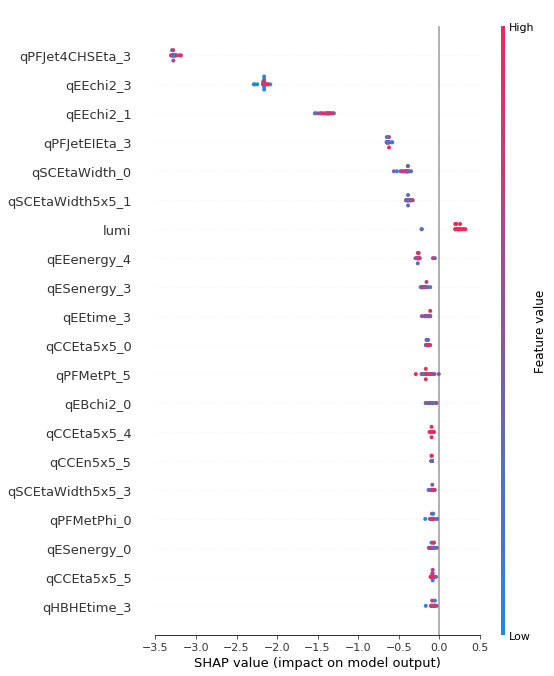

shap for channel for lumi
          PF      calo     muons   photons
0  -4.480931 -0.311185  0.061625 -0.085685
1  -4.464724  0.028613  0.044134  0.029672
2  -4.263342  0.024582 -0.097151 -0.027435
3  -4.375052 -0.087929 -0.164838 -0.017423
4  -4.066766 -0.112606 -0.141677  0.068530
5  -4.212752 -0.075685 -0.092109 -0.064989
6  -4.059303 -0.044144 -0.008511 -0.133038
7  -3.807808 -0.080906 -0.007363 -0.016384
8  -3.819469  0.165778 -0.025631 -0.034982
9  -4.016434 -0.022186  0.079831 -0.046430
10 -4.337837 -0.040294 -0.090593 -0.031276
11 -4.081968 -0.013578  0.060605 -0.046782
12 -4.289302 -0.034557 -0.002195 -0.081137
13 -4.237392  0.030834  0.152573 -0.069418
14 -4.084047 -0.014159  0.073333 -0.041775
15 -4.108532  0.066271  0.005398 -0.151719
16 -4.376708  0.113550 -0.019795 -0.076229
 
shap for channel for run
PF        -71.082368
calo       -0.407601
muons      -0.172366
photons    -0.826500
dtype: float64
 
________________________________________________________________________

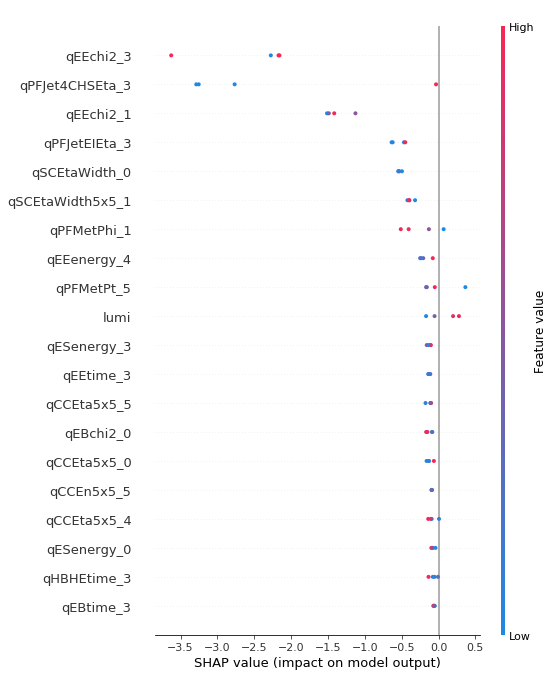

shap for channel for lumi
         PF      calo     muons   photons
0 -4.066446  0.043025  0.097570  0.019787
1 -4.539039  0.050187 -0.141858 -0.125326
2 -3.363135  0.137434  0.169866 -0.176469
3 -0.945124  0.020748 -0.232656 -0.343954
 
shap for channel for run
PF        -12.913744
calo        0.251394
muons      -0.107078
photons    -0.625962
dtype: float64
 
____________________________________________________________________________________________________

275764  [[1, 31]],			pixel off

this run from TRAIN set
sum of features' influences from all lumis, 20 the most important

Index(['qEEchi2_3', 'qPFMetPhi_1', 'qEEchi2_1', 'qPFJet4CHSEta_3',
       'qPFMetPhi_5', 'qPFJetEIEta_3', 'qPFJetPhi_5', 'qSCEtaWidth5x5_1',
       'qEEtime_3', 'qSCEtaWidth_0', 'qEBchi2_0', 'qPFJetPhi_0', 'qMuPhi_5',
       'qEBenergy_5', 'qESenergy_3', 'qPFMetPt_5', 'qEEenergy_4',
       'qPFMetPhi_4', 'lumi', 'qPFMetPhi_0'],
      dtype='object')

the most common features with big shap values

Index(['qEE

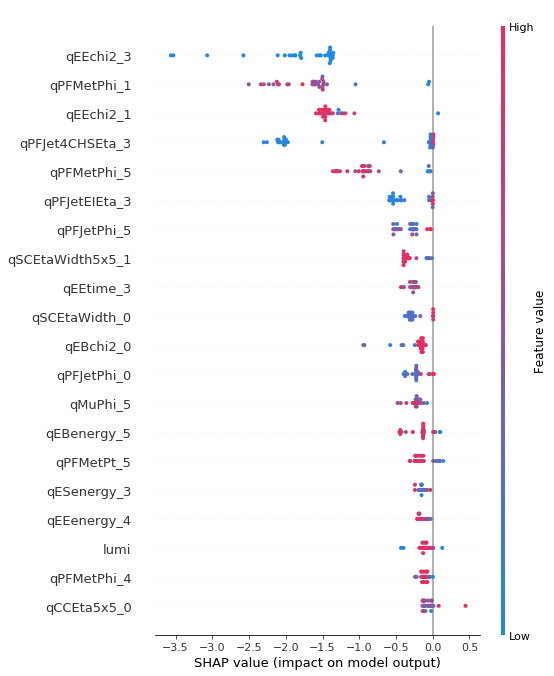

shap for channel for lumi
          PF      calo     muons   photons
0  -2.691367 -0.208528 -0.637027  0.086595
1  -1.033206 -0.319695 -0.316106 -0.144838
2  -2.770467 -0.151827 -0.387826 -0.423931
3  -4.217427 -0.168139 -0.580438  0.007884
4  -4.800518  0.154297 -0.275665  0.005598
5  -3.500451 -0.339677 -0.395345 -0.225100
6  -0.938572 -0.247349 -0.299980 -0.031750
7  -5.767483  0.108732 -0.340285  0.004691
8  -5.382938  0.127485 -0.208420  0.002612
9  -5.308576 -0.102331 -0.337830 -0.093058
10 -5.941640 -0.005802 -0.204136 -0.015078
11 -6.058883  0.056901 -0.193921 -0.166297
12 -6.183829  0.002377 -0.230265  0.019943
13 -6.003539  0.019372 -0.353853 -0.069530
14 -5.837561  0.066013 -0.211265  0.073161
15 -6.094262  0.036267 -0.178112 -0.149152
16 -5.591837 -0.134409 -0.178414 -0.077475
17 -6.236649  0.025414 -0.282204 -0.019350
18 -6.069001  0.029318 -0.292206  0.000019
19 -6.068723  0.094107 -0.381210 -0.114056
20 -6.148722  0.113655 -0.212591  0.028571
21 -5.847489 -0.040581 -0.27

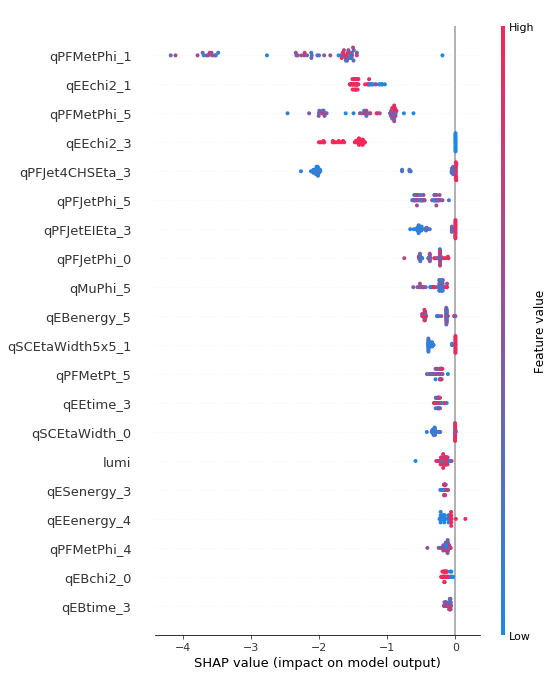

shap for channel for lumi
          PF      calo     muons   photons
0  -4.908292  0.039050 -0.279551 -0.036543
1  -6.116286  0.127903 -0.188708  0.025025
2  -4.897636  0.000473 -0.316865  0.137016
3  -6.115940  0.142883 -0.196327 -0.002732
4  -6.040341  0.053795 -0.349177 -0.120878
5  -6.155712  0.037644 -0.250108  0.043688
6  -6.054021 -0.047264 -0.158921 -0.013266
7  -6.035373  0.103220 -0.190470  0.012760
8  -5.677055  0.040499 -0.259400 -0.105246
9  -5.238450  0.085549 -0.211542 -0.079465
10 -6.090275 -0.037493 -0.299963  0.021839
11 -5.651106 -0.055158 -0.079000  0.077782
12 -6.039999 -0.039125 -0.176047 -0.029638
13 -6.007029  0.030210 -0.221989 -0.119813
14 -5.870022  0.157652 -0.217667 -0.084606
15 -5.809810  0.013983 -0.158457 -0.040475
16 -6.047771  0.191054 -0.133288 -0.054626
17 -5.560540 -0.029584 -0.220868 -0.045477
18 -6.363060 -0.018629 -0.341951 -0.020036
19 -5.003927  0.099033 -0.339018 -0.065505
20 -6.261086  0.089416 -0.178929 -0.135411
21 -5.513042 -0.030904 -0.24

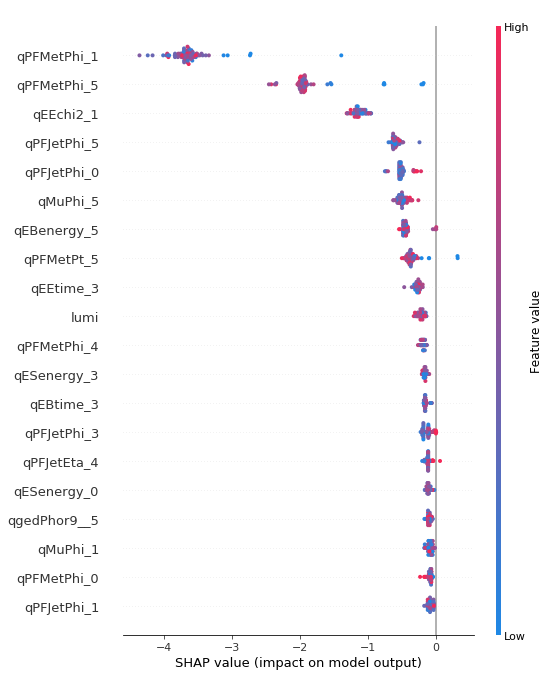

shap for channel for lumi
          PF      calo     muons   photons
0  -7.514956  0.073680 -0.570627 -0.084646
1  -7.883093 -0.030464 -0.725244  0.083760
2  -7.296569 -0.072055 -0.670896  0.074012
3  -7.692669 -0.011377 -0.646535  0.086953
4  -7.542675 -0.068124 -0.768697  0.133434
5  -7.753272 -0.021956 -0.634180  0.032811
6  -7.774970  0.008443 -0.686979  0.116104
7  -7.406050  0.088079 -0.523167  0.044981
8  -7.269684 -0.084631 -0.655051  0.181659
9  -7.222670  0.061181 -0.603709  0.020746
10 -7.718063 -0.008409 -0.712558  0.121485
11 -7.458782  0.189805 -0.723338  0.085860
12 -7.442698 -0.103592 -0.676952  0.019966
13 -7.122521 -0.024987 -0.632374  0.082890
14 -6.808794 -0.028314 -0.811212  0.118204
15 -7.676033  0.035017 -0.632686  0.136379
16 -7.494928  0.167038 -0.690544  0.051475
17 -7.714595 -0.025889 -0.532001  0.011785
18 -7.947443 -0.065660 -0.709955  0.073051
19 -5.567271 -0.267973 -0.672254  0.072918
20 -7.958593  0.014327 -0.406199  0.025424
21 -7.882937 -0.106560 -0.73

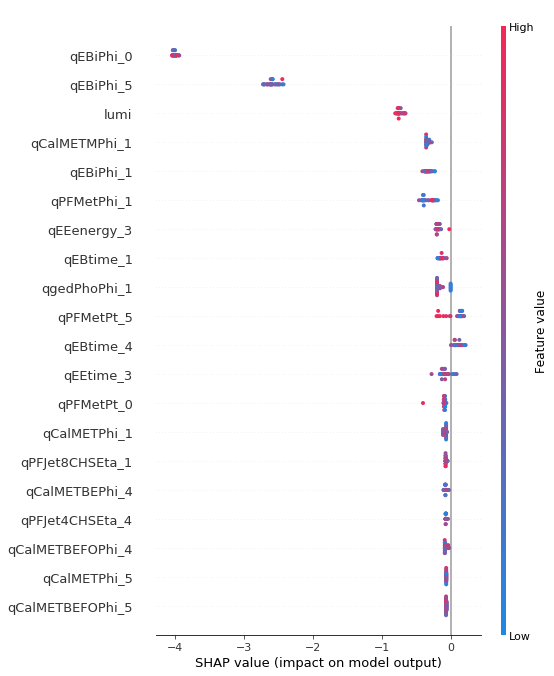

shap for channel for lumi
          PF      calo     muons   photons
0  -0.683443 -1.100250 -0.096531 -0.110985
1  -0.943994 -1.124269  0.092371 -0.020137
2  -1.020036 -1.117755  0.038461 -0.077497
3  -0.862463 -1.167700  0.040273 -0.019720
4  -0.662206 -1.201235  0.057556 -0.201828
5  -1.062818 -1.003624 -0.040736 -0.241518
6  -0.853715 -1.078456  0.111101 -0.049063
7  -0.433053 -1.175389  0.063316 -0.085657
8  -0.869391 -0.959071  0.006789 -0.109844
9  -0.691347 -1.003728 -0.010747 -0.078152
10 -0.498066 -1.015760  0.002909 -0.103174
11 -0.567391 -1.048307  0.107977 -0.031252
12 -0.701145 -1.011767  0.018813 -0.065249
13 -0.826532 -1.184089  0.018391 -0.009254
14 -1.005093 -1.080653  0.056451 -0.008231
15 -0.625206 -1.046084  0.018988 -0.055745
16 -0.592922 -1.089887  0.089458 -0.015623
17 -0.649803 -1.200980 -0.044651  0.005362
18 -0.509336 -1.194661  0.034699 -0.070906
19 -0.473712 -1.091632  0.125411 -0.012934
20 -0.565729 -1.000997  0.015684  0.014543
21 -0.424336 -0.957973  0.01

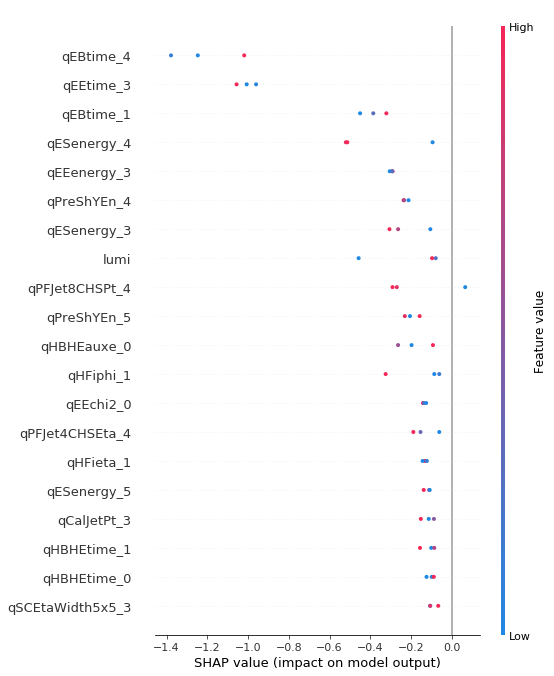

shap for channel for lumi
         PF      calo     muons   photons
0 -0.850799 -0.435677 -0.140928 -0.276381
1 -1.025683 -0.573678  0.001643 -0.087827
2 -1.195430 -0.630699 -0.201622 -0.145415
 
shap for channel for run
PF        -3.071912
calo      -1.640054
muons     -0.340906
photons   -0.509622
dtype: float64
 
____________________________________________________________________________________________________
276064 is not found
276071 is not found

276095  [[1, 5]],			low stat

this run from TRAIN set
sum of features' influences from all lumis, 20 the most important

Index(['lumi', 'qEEchi2_1', 'qEBenergy_5', 'qEBchi2_0', 'qPFJet4CHSEta_3',
       'qPFJetEta_1', 'qPFMetPt_5', 'qEEtime_1', 'qSCEtaWidth_0',
       'qPFJetEta_3', 'qPFJetEIEta_3', 'qEBiPhi_1', 'qPFJet5Eta_0',
       'qCalMETBEPhi_2', 'qPhomaxenxtal__5', 'qEBtime_4', 'qSCEtaWidth5x5_3',
       'qESenergy_3', 'qHBHEtime_3', 'qCCPhi5x5_6'],
      dtype='object')

the most common features with big shap values

Index(['l

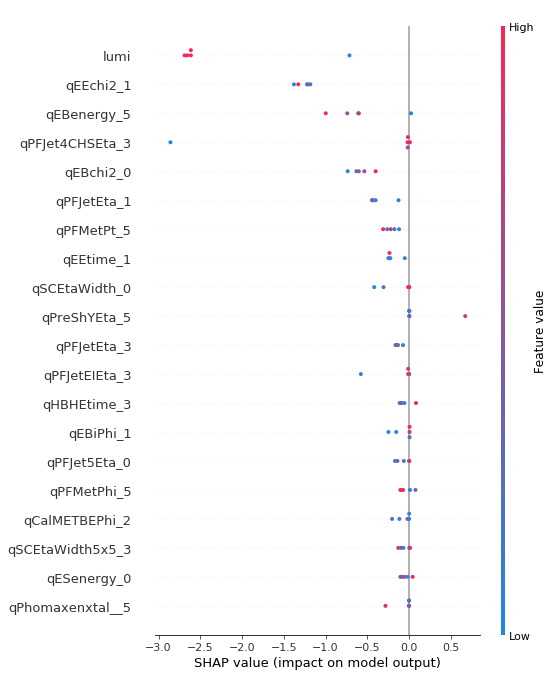

shap for channel for lumi
         PF      calo     muons   photons
0 -1.934225 -0.291967 -0.124227 -0.319623
1 -1.602892 -0.501380 -0.297347 -0.127083
2 -1.271193 -0.442608 -0.304477 -0.483947
3 -1.749956 -0.167036 -0.092144 -0.083618
4 -4.581241 -0.672450 -0.029779 -0.216555
 
shap for channel for run
PF        -11.139507
calo       -2.075439
muons      -0.847975
photons    -1.230827
dtype: float64
 
____________________________________________________________________________________________________
276237 is not found

276453  [[1, 8], [10, 125]],		EB-17 (FED 626): was excluded (because of cooling failure)

this run from TRAIN set
sum of features' influences from all lumis, 20 the most important

Index(['qEBiPhi_0', 'qEBiPhi_5', 'qEBiPhi_1', 'lumi', 'qEEenergy_3',
       'qEBtime_4', 'qEBtime_1', 'qEBiPhi_4', 'qSCEtaWidth_0',
       'qSCEtaWidth5x5_1', 'qHBHEtime_1', 'qHBHEauxe_0', 'qEBenergy_5',
       'qPFMetPhi_1', 'qCalMETMPhi_1', 'qCalMETBEFOPhi_5', 'qPFJet8CHSEta_1',
       'q

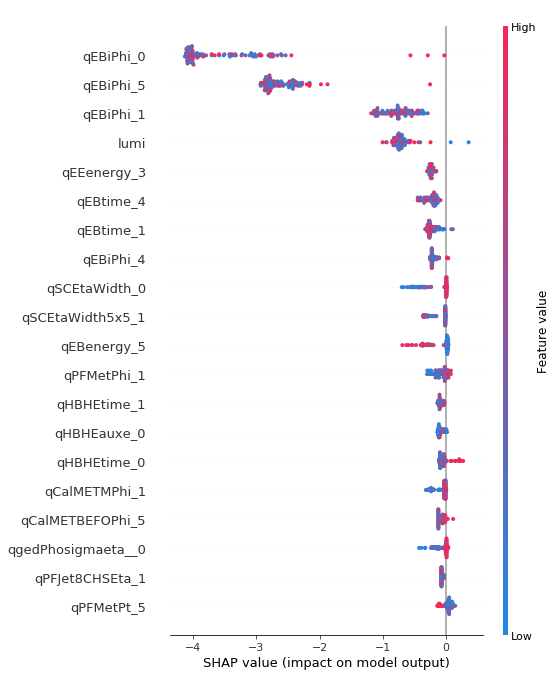

shap for channel for lumi
           PF      calo     muons   photons
0   -0.367743 -0.378922  0.024032 -0.155805
1   -0.419268 -0.909160  0.082257  0.027472
2   -0.164030 -0.279305  0.048210 -0.027402
3   -0.105581 -0.623691  0.127599 -0.099339
4   -0.214790 -0.391531  0.179732 -0.101739
5   -0.419663 -0.764590  0.011703 -0.012123
6   -0.669243 -0.957081 -0.021449 -0.061395
7   -1.868776 -0.514251  0.111449 -0.515511
8   -1.308416 -0.579156  0.080654 -0.411247
9   -1.080147 -0.410182  0.117272 -0.373114
10  -0.940457 -0.561287  0.025675 -0.474983
11  -0.681657 -0.203601  0.120238 -0.361823
12  -1.006569 -0.204484 -0.176451 -0.368070
13  -0.741003  0.167457 -0.238439 -0.407377
14  -1.079935 -0.239887 -0.097363 -0.363288
15  -0.915830 -0.443253 -0.000032 -0.328944
16  -1.574906 -0.663276 -0.160563 -0.517671
17  -1.622814 -0.090094 -0.206867 -0.679443
18  -1.145109 -0.563352 -0.215112 -0.296028
19  -0.983944 -0.160478 -0.161963 -0.425647
20  -0.730252 -0.577062 -0.157454 -0.279229
21  -0

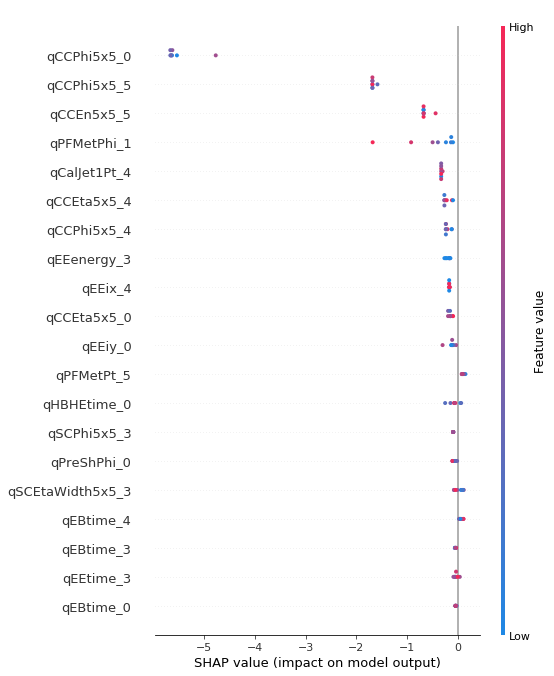

shap for channel for lumi
         PF      calo     muons   photons
0 -0.017121 -0.429733  0.127486  0.022872
1 -0.995557 -0.554841 -0.035827 -0.034690
2 -0.339343 -0.442611  0.093597  0.019072
3 -0.335203 -0.576661  0.016841  0.009385
4 -1.758022 -0.674648 -0.085833 -0.065206
5 -0.199650 -0.426586 -0.036304  0.032424
6 -0.067054 -0.528119  0.085096  0.058332
7  0.076540 -0.441331  0.124999  0.004993
 
shap for channel for run
PF        -3.635410
calo      -4.074530
muons      0.290055
photons    0.047183
dtype: float64
 
____________________________________________________________________________________________________

278821  [[1, 33], [36, 37]],		FED652 in error, EE+04 is off

this run from TRAIN set
sum of features' influences from all lumis, 20 the most important

Index(['qCCPhi5x5_0', 'qPFMetPhi_1', 'qCCPhi5x5_5', 'qCCEta5x5_0',
       'qCCEn5x5_5', 'qCCPhi5x5_4', 'qCalJet1Pt_4', 'qEEiy_0', 'qEEenergy_3',
       'qEEix_4', 'qCalJet3Pt_4', 'qHBHEtime_0', 'qPreShPhi_0', 'qgedPhor

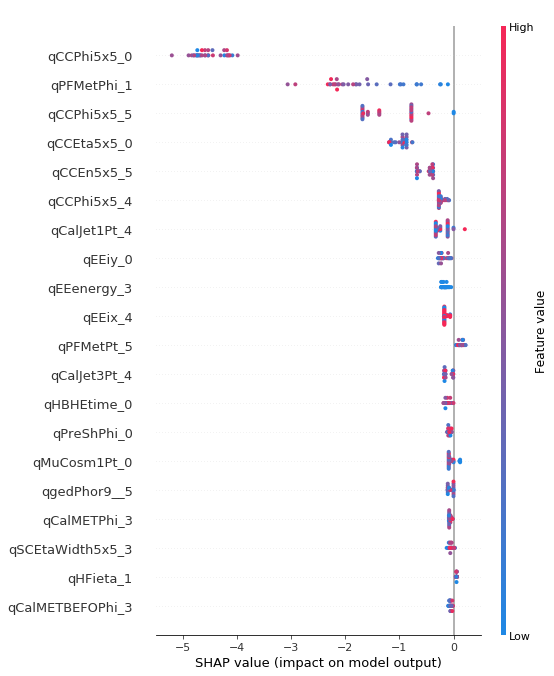

shap for channel for lumi
          PF      calo     muons   photons
0  -1.526824 -0.522516 -0.178109  0.054819
1  -2.034884 -0.684983 -0.065346 -0.200901
2  -2.096270 -0.609091 -0.023937  0.049069
3  -2.229792 -0.543472  0.028532 -0.002406
4  -2.242228 -0.692549 -0.030018 -0.034707
5  -1.889997 -0.605115 -0.046488  0.014733
6  -2.709890 -0.271474 -0.067628 -0.005725
7  -0.759280 -0.464586 -0.125208  0.083225
8  -3.120661 -0.340108  0.037049  0.064131
9  -2.430041 -0.679483 -0.081424  0.029959
10 -1.578063 -0.630096 -0.035183 -0.047202
11 -1.028936 -0.648706  0.163547  0.056610
12 -1.634445 -0.752388 -0.061436 -0.035359
13 -0.156432 -0.549681  0.076858  0.028234
14 -2.180285 -0.516534 -0.074565 -0.003812
15 -0.716921 -0.512866  0.036888  0.038872
16 -2.106353 -0.815535 -0.119088  0.010872
17 -1.009543 -0.444646 -0.051950 -0.025501
18 -0.307258 -0.610163  0.046323  0.046316
19 -1.566120 -0.738035 -0.021772  0.013501
20 -2.242798 -0.436218 -0.048522 -0.030528
21 -1.379151 -0.731144  0.28

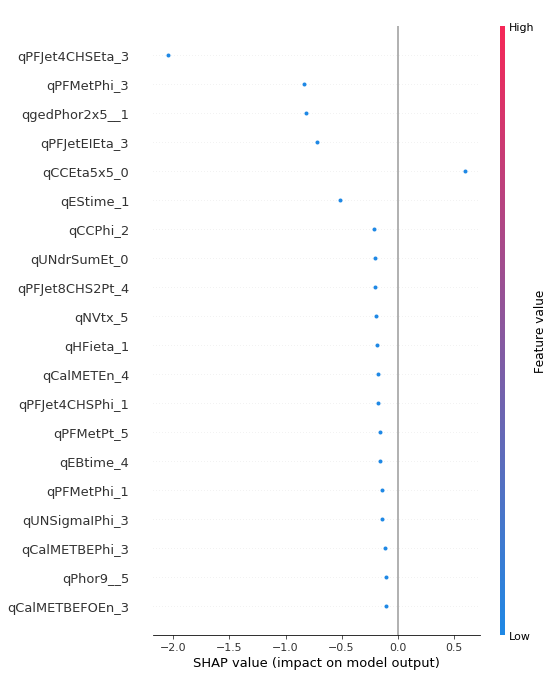

shap for channel for lumi
         PF      calo     muons   photons
0 -5.181176 -1.047123 -0.300973 -0.320993
 
shap for channel for run
PF        -5.181176
calo      -1.047123
muons     -0.300973
photons   -0.320993
dtype: float64
 
____________________________________________________________________________________________________
280002 is not found

280006  [[1, 68]],			EB-11 token ring missing

this run from TRAIN set
sum of features' influences from all lumis, 20 the most important

Index(['qPFMetPhi_1', 'qCalMETBEPhi_1', 'qHFieta_1', 'qCalMETBEPhi_3',
       'qSCPhi_1', 'qEBtime_0', 'qCalMETBEFOPhi_3', 'qPFMetPt_5',
       'qCalJet3Pt_4', 'qEBenergy_5', 'qEBiPhi_1', 'qCCPhi_1', 'qgedPhor9__5',
       'qPreShEn_4', 'qPFMetPhi_3', 'qPFJet4CHSPhi_0', 'qCalJetPt_3',
       'qEBtime_3', 'qPFJet8CHS5Pt_1', 'qCalMETEn_4'],
      dtype='object')

the most common features with big shap values

Index(['qPFMetPhi_1', 'qHFieta_1', 'qSCPhi_1', 'qCalMETBEFOPhi_3',
       'qPFMetPt_5', 'qEBiPh

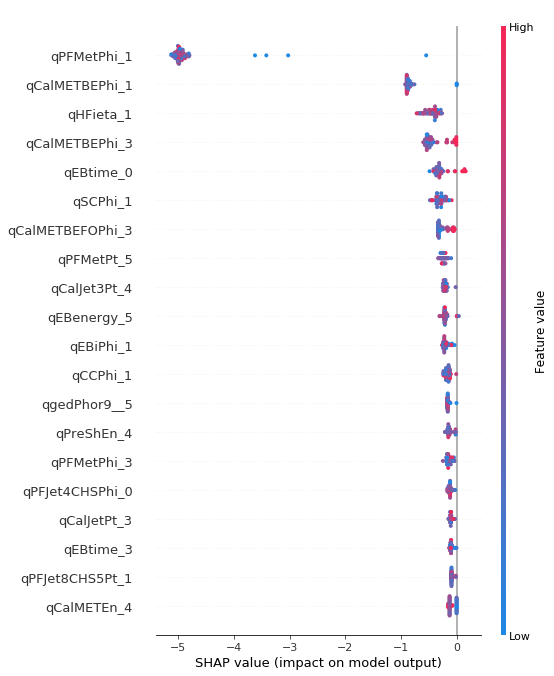

shap for channel for lumi
          PF      calo     muons   photons
0  -6.058166 -2.462731 -0.100720 -0.100980
1  -5.891794 -1.842641  0.107395  0.017513
2  -3.963906 -1.743998 -0.212764 -0.217888
3  -6.106144 -2.505621 -0.011331 -0.075714
4  -6.036377 -2.532761 -0.129589 -0.078085
5  -5.925825 -2.080910  0.031239 -0.079204
6  -5.841641 -2.513426 -0.007466 -0.163330
7  -6.125124 -2.559343  0.051405 -0.026739
8  -5.961860 -2.526858  0.099739 -0.185145
9  -6.155635 -2.539698 -0.012126 -0.002515
10 -5.903775 -2.483135  0.135610 -0.212210
11 -6.003523 -2.642015 -0.038475 -0.024331
12 -6.110198 -2.638155 -0.116084 -0.135680
13 -6.164195 -2.650187  0.039890 -0.044096
14 -6.212756 -2.549198 -0.164612 -0.031139
15 -4.646801 -2.289896  0.018758 -0.192752
16 -5.945683 -2.565698  0.032617 -0.072839
17 -5.712776 -2.281295 -0.068980  0.083087
18 -1.378419 -2.482317 -0.018051 -0.147915
19 -4.379586 -2.637528 -0.031325 -0.088598
20 -6.133733 -3.323997  0.014786 -0.086857
21 -5.723449 -2.377832 -0.08

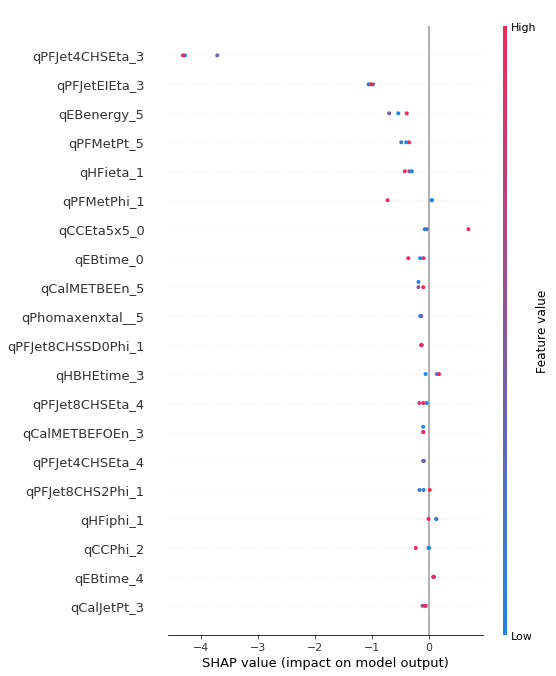

shap for channel for lumi
         PF      calo     muons   photons
0 -6.852889 -0.727082 -0.020850 -0.449455
1 -7.386769 -0.578108 -0.025756 -0.404102
2 -6.166199 -0.584850 -0.402144 -0.324461
 
shap for channel for run
PF        -20.405857
calo       -1.890039
muons      -0.448751
photons    -1.178018
dtype: float64
 
____________________________________________________________________________________________________
280239 is not found
280241 is not found
281663 is not found
281674 is not found
281680 is not found
281974 is not found
282408 is not found
282707 is not found
282796 is not found
282921 is not found


In [18]:
for run in dict_causes.keys():
    if run in sublabels['runId'].values:
        print('')
        print (run, dict_causes[run])
        print('')
        
        if run in ids_train['runId'].values:
            print ('this run from TRAIN set')
            shap_values = shap_values_train
            search_for_ind = ids_train
            X = X_train
            
        else:
            print ('this run from TEST set')
            shap_values = shap_values_test
            search_for_ind = ids_test
            X = X_test
            
        
        inds = np.where(np.array(search_for_ind)==run)[0]

        print ("sum of features' influences from all lumis, 20 the most important")
        print('')
        sum_shap = np.sum(shap_values[inds,:-1], axis=0)
        print (feature_names[np.argsort(sum_shap, axis=0)][:20])
        print('')
        print("the most common features with big shap values")
        print('')
        top_sh_values = np.argsort(shap_values[inds,:-1], axis=1)[:,:50].T.reshape(-1)
        unique, first_index, counts = np.unique(
            top_sh_values,
        return_counts=True, return_index=True)
        print(feature_names[top_sh_values[np.sort(first_index[counts == len(inds)])]])
        print('')
        #random example 
        #shap.force_plot(shap_values[np.random.choice(inds,1),:], feature_names)
        shap.summary_plot(shap_values[inds,:], features=X[inds, :], feature_names=feature_names)
        
        channels_shap = pd.DataFrame()

        for i in shap_values[inds,:-1]:

            pred_for_channnel = {}
            for channel in channels_features:
                current_sum = 0
                for feature in channels_features[channel]:
                    current_sum += i[list(feature_names).index(feature)]
                pred_for_channnel[channel] = current_sum
            channels_shap = channels_shap.append(pred_for_channnel, ignore_index=True)

        print ('shap for channel for lumi')
        print (channels_shap)
        print(" ")
        print ('shap for channel for run')
        print(channels_shap.sum())
        print(" ")
        print("_"*100)
        
    else:
        print (str(run) +' is not found')

## some examples for one sample seperately

##  "275768": [[1, 79]],			lower tracker efficiency

In [19]:
inds = np.where(np.array(ids_train)==275768)[0]
inds

array([582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
       595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607,
       608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620,
       621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633,
       634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646,
       647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657])

In [20]:
shap.force_plot(shap_values_train[583,:], feature_names[:])

In [21]:
shap.force_plot(shap_values_train[617,:], feature_names[:])

In [22]:
shap.force_plot(shap_values_train[656,:], feature_names[:])

##  "279995": [[1, 8]],			hcal water colling issues

In [23]:
np.where(np.array(ids_train)==279995)

(array([108963]), array([0]))

In [24]:
shap.force_plot(shap_values_train[108963,:], feature_names[:])

##  "275764": [[1, 31]],			pixel off

In [25]:
inds = np.where(np.array(ids_train)==275764)[0]
inds

array([494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506,
       507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
       520, 521, 522, 523])

In [26]:
shap.force_plot(shap_values_train[500,:], feature_names[:])

In [27]:
shap.force_plot(shap_values_train[523,:], feature_names[:])

##  "275758": [[1, 4]],			part of hcal not available --> JetMET reconstruction suffers


In [28]:
np.where(np.array(ids_train)==275758)

(array([476, 477, 478, 479]), array([0, 0, 0, 0]))

In [29]:
shap.force_plot(shap_values_train[476,:], feature_names[:])

In [30]:
shap.force_plot(shap_values_train[478,:], feature_names[:])

##  "275757": [[104, 122]],		low DCS: HBHE. nothing on PF plot.

In [31]:
np.where(np.array(ids_train)==275757)[0]

array([459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471,
       472, 473, 474, 475])

In [32]:
shap.force_plot(shap_values_train[459,:], feature_names)

In [33]:
shap.force_plot(shap_values_train[460,:], feature_names)

In [34]:
shap.force_plot(shap_values_train[461,:], feature_names)

In [35]:
shap.force_plot(shap_values_train[475,:], feature_names)

##  "280007": [[1, 36]],			Low voltage channel broken in EB-

In [36]:
np.where(np.array(ids_train)==280007)

(array([109030, 109031, 109032]), array([0, 0, 0]))

In [37]:
shap.force_plot(shap_values_train[109030,:], feature_names=feature_names)

In [38]:
shap.force_plot(shap_values_train[109031,:], feature_names=feature_names)

In [39]:
shap.force_plot(shap_values_train[109032,:], feature_names=feature_names)